#Importing libraries, loading and pre-processing the dataset

In [ ]:
from google.colab import drive
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.feature import hog
from skimage import exposure, io
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def load_images_from_folder(folder, class_labels):
    images = []
    labels = []
    for class_label, class_folder in enumerate(class_labels):
        class_path = os.path.join(folder, class_folder)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = io.imread(img_path)
            if len(img.shape) > 2 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))
            if img is not None:
                images.append(img)
                labels.append(class_label)
    print(f"Loaded {len(images)} images from {folder}")
    return images, labels


In [ ]:
# Define folder paths and class labels
train_folder = '/content/drive/MyDrive/CastingData/train'
test_folder = '/content/drive/MyDrive/CastingData/test'
class_labels = ['def_front', 'ok_front']

# Load images
train_images, train_labels = load_images_from_folder(train_folder, class_labels)
test_images, test_labels = load_images_from_folder(test_folder, class_labels)

# Combine images and labels
X = np.array(train_images + test_images)
y = np.array(train_labels + test_labels)
print("Data preprocessing complete.")


Loaded 6276 images from /content/drive/MyDrive/CastingData/train
Loaded 715 images from /content/drive/MyDrive/CastingData/test
Data preprocessing complete.


#HOG Feature extraction and PCA

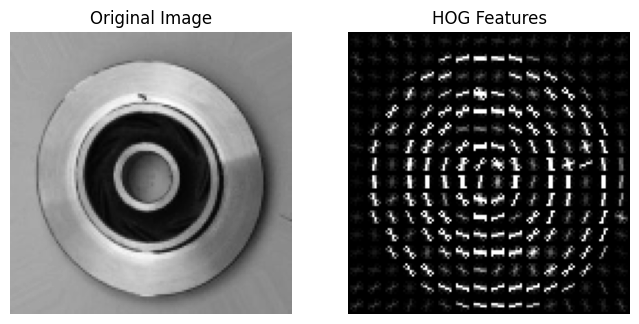

In [ ]:
def extract_hog_features(image):
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return fd, hog_image_rescaled

def visualize_hog(original_image, hog_image_rescaled):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(hog_image_rescaled, cmap='gray')
    axes[1].set_title('HOG Features')
    axes[1].axis('off')
    plt.show()

# Example usage of the functions
random_index = random.randint(0, len(X) - 1)
original_image = X[random_index].astype(np.float32)  # Convert to float32 for HOG processing

# Extract HOG features and visualize
hog_features, hog_image_rescaled = extract_hog_features(original_image)
visualize_hog(original_image, hog_image_rescaled)


Applied PCA on HOG features.


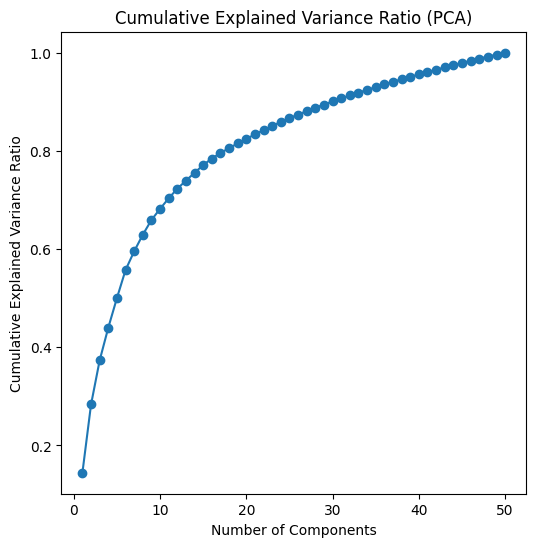

Selected features: [40  8 49  1  3  9  4 10 42  5]


In [ ]:
def flatten_images(images):
    return np.array([img.flatten() for img in images])

def visualize_feature_reduction(X):
    pca = PCA()
    pca.fit(X)
    cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(6, 6))
    num_components = range(1, len(cum_explained_variance) + 1)
    plt.plot(num_components, cum_explained_variance, marker='o')
    plt.title('Cumulative Explained Variance Ratio (PCA)')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.show()

def select_features(X, num_features):
    pca = PCA().fit(X)
    X_pca = pca.transform(X)
    selected_features = np.argsort(np.mean(X_pca, axis=0))[-num_features:]
    return selected_features

# Extract and flatten HOG features
hog_features = [extract_hog_features(img)[0] for img in X]  # Extract only the feature descriptor
X_flattened_hog = flatten_images(hog_features)

# Apply PCA on flattened HOG features
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_flattened_hog)
print("Applied PCA on HOG features.")

# Visualize feature reduction
visualize_feature_reduction(X_pca)

# Select features
selected_features = select_features(X_pca, num_features=10)
print("Selected features:", selected_features)


#Applying and evaluating machine learning Techniques


*   kNN
*   Logistic Regression
*   SVM
*   Naive-Bayes'
*   Random Forest
*   Decision Trees

> *   Bagging/Boosting






Evaluating knn classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       850
           1       0.93      0.99      0.96       549

    accuracy                           0.96      1399
   macro avg       0.96      0.97      0.96      1399
weighted avg       0.97      0.96      0.96      1399

Confusion Matrix:
[[807  43]
 [  7 542]]


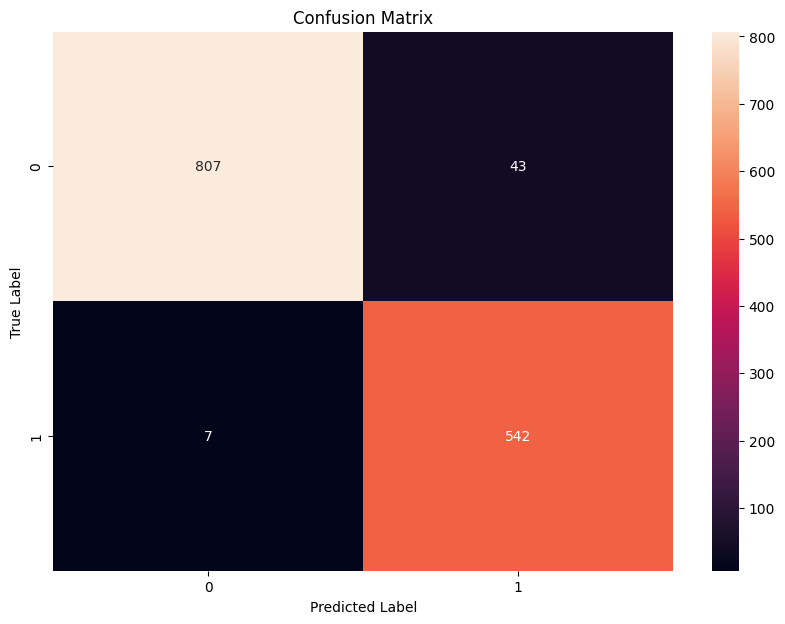

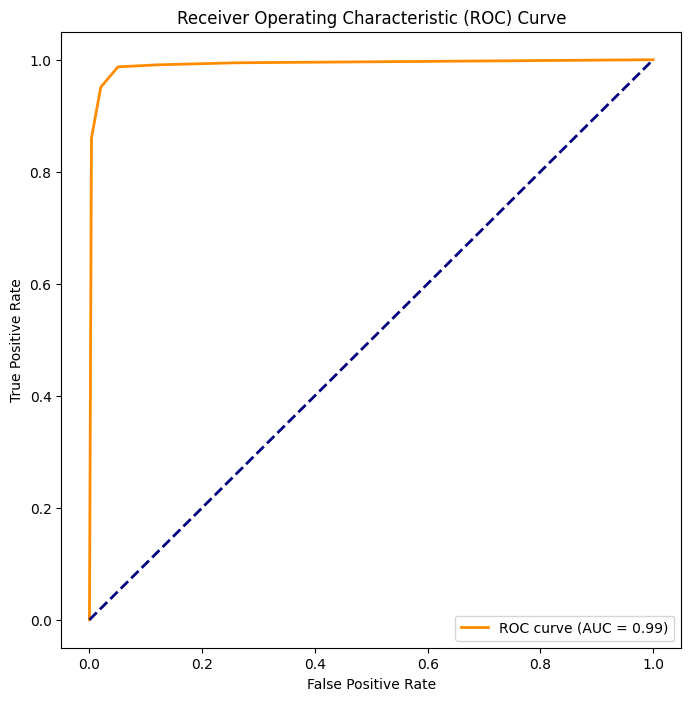

Cross-validation scores: [0.95710456 0.95710456 0.96332737 0.95617174 0.95080501]
Mean CV accuracy: 0.9569026459543325
Evaluating log_reg classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       850
           1       0.88      0.91      0.89       549

    accuracy                           0.91      1399
   macro avg       0.91      0.91      0.91      1399
weighted avg       0.92      0.91      0.92      1399

Confusion Matrix:
[[782  68]
 [ 51 498]]


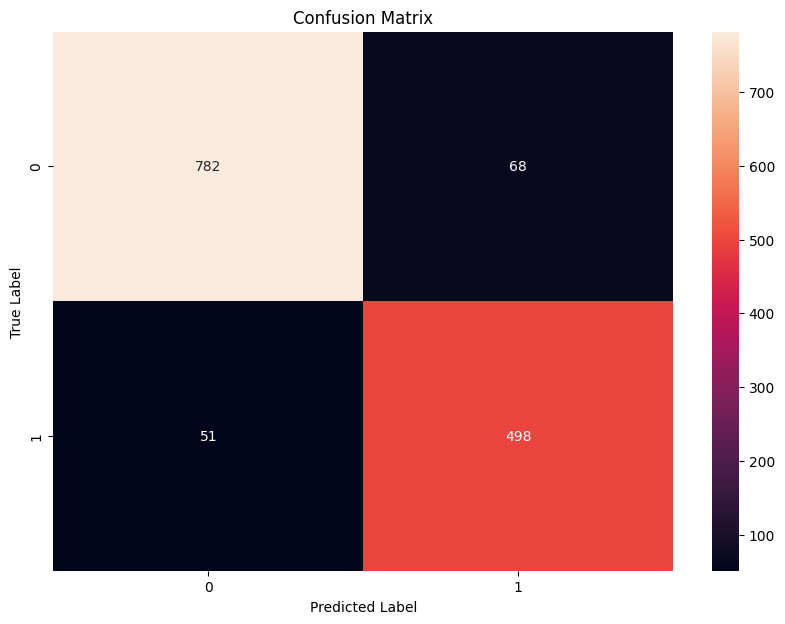

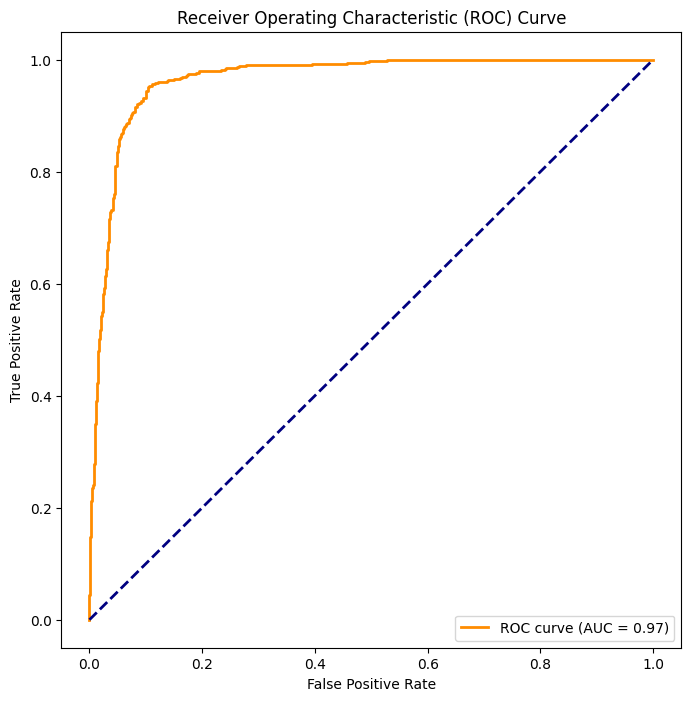

Cross-validation scores: [0.89276139 0.89544236 0.89087657 0.89982111 0.8881932 ]
Mean CV accuracy: 0.8934189259833003
Evaluating svm classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       850
           1       0.97      0.98      0.98       549

    accuracy                           0.98      1399
   macro avg       0.98      0.98      0.98      1399
weighted avg       0.98      0.98      0.98      1399

Confusion Matrix:
[[832  18]
 [  9 540]]


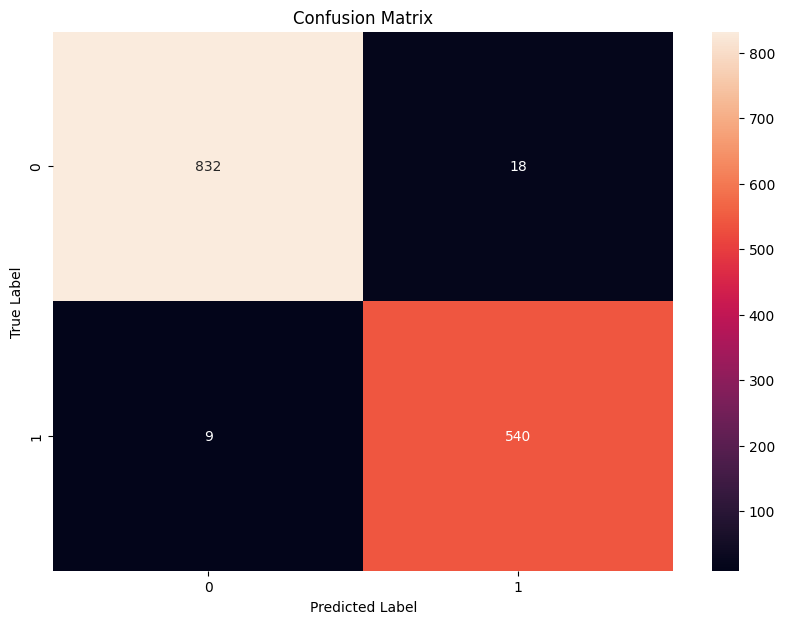

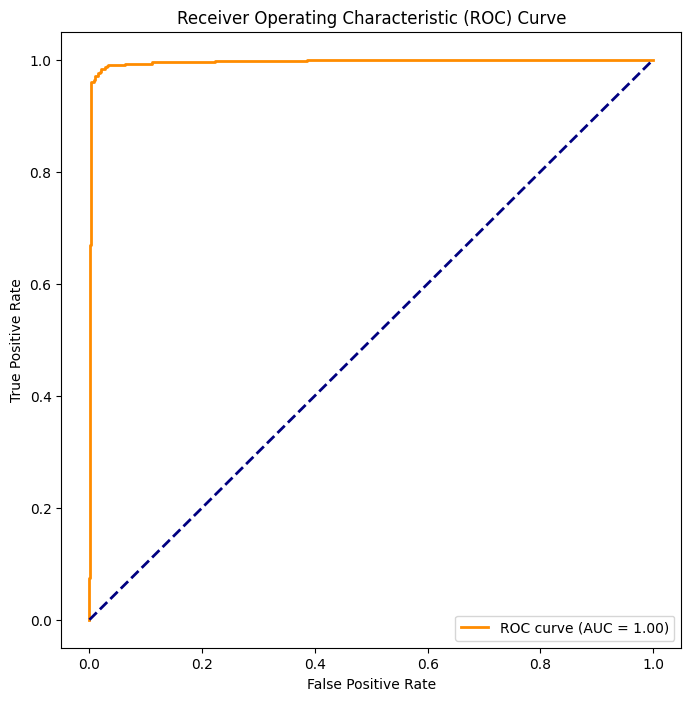

Cross-validation scores: [0.96514745 0.96693476 0.97674419 0.97763864 0.97316637]
Mean CV accuracy: 0.9719262822511154
Evaluating naive_bayes classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       850
           1       0.87      0.89      0.88       549

    accuracy                           0.90      1399
   macro avg       0.90      0.90      0.90      1399
weighted avg       0.90      0.90      0.90      1399

Confusion Matrix:
[[776  74]
 [ 61 488]]


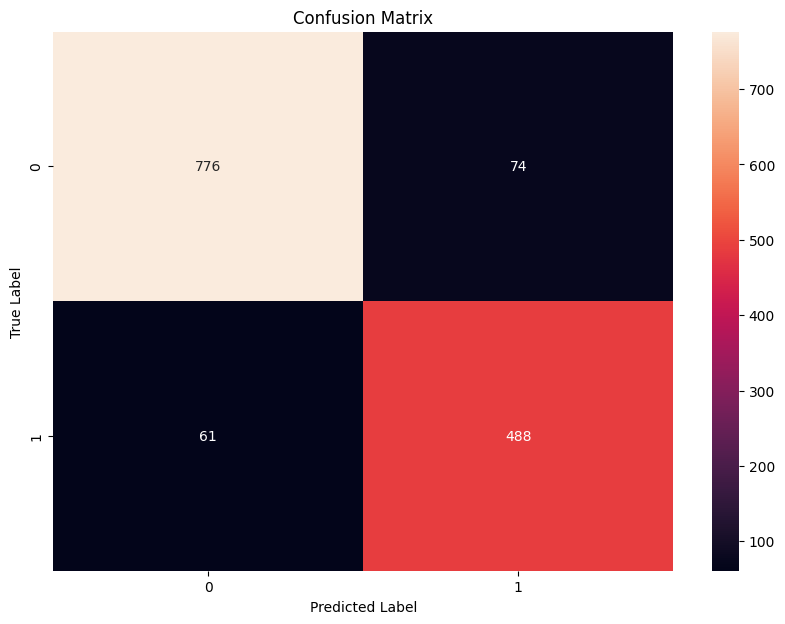

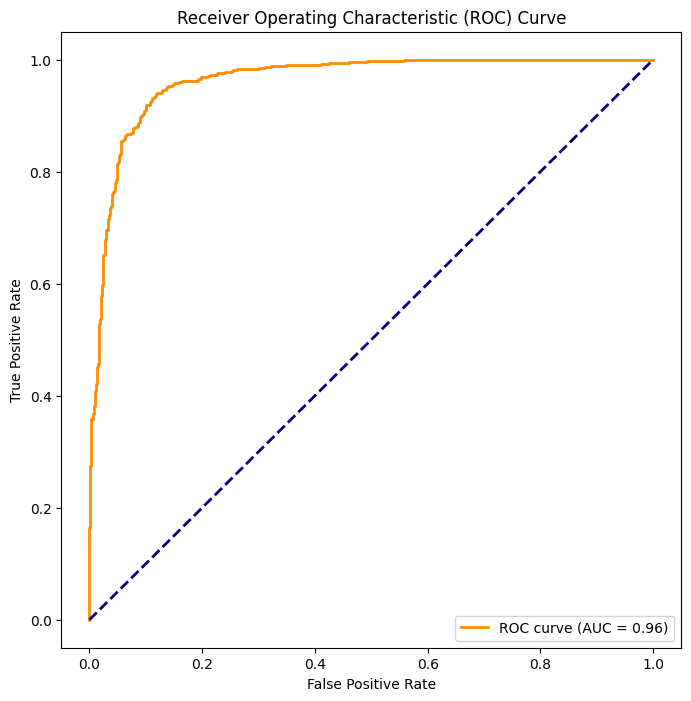

Cross-validation scores: [0.89722967 0.89365505 0.87924866 0.88640429 0.88282648]
Mean CV accuracy: 0.8878728292095708
Evaluating random_forest classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       850
           1       0.95      0.93      0.94       549

    accuracy                           0.95      1399
   macro avg       0.95      0.95      0.95      1399
weighted avg       0.95      0.95      0.95      1399

Confusion Matrix:
[[822  28]
 [ 36 513]]


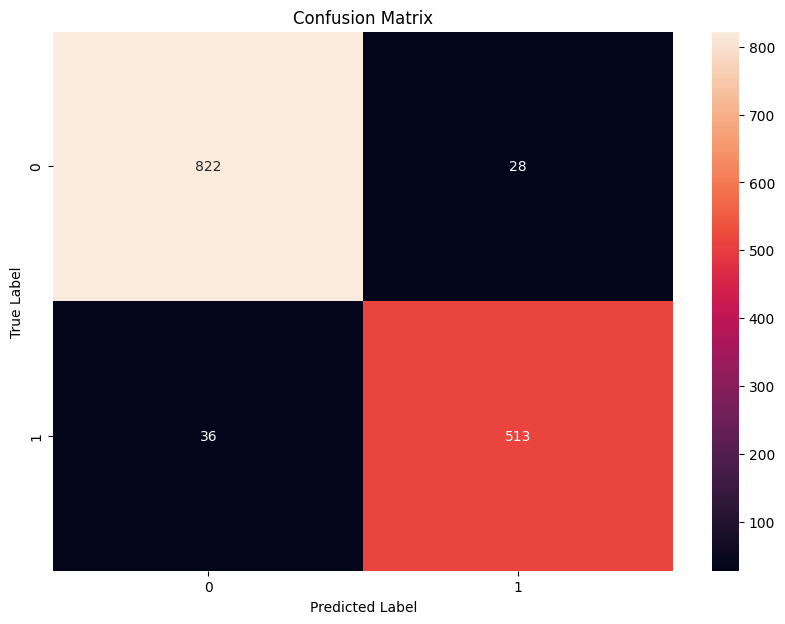

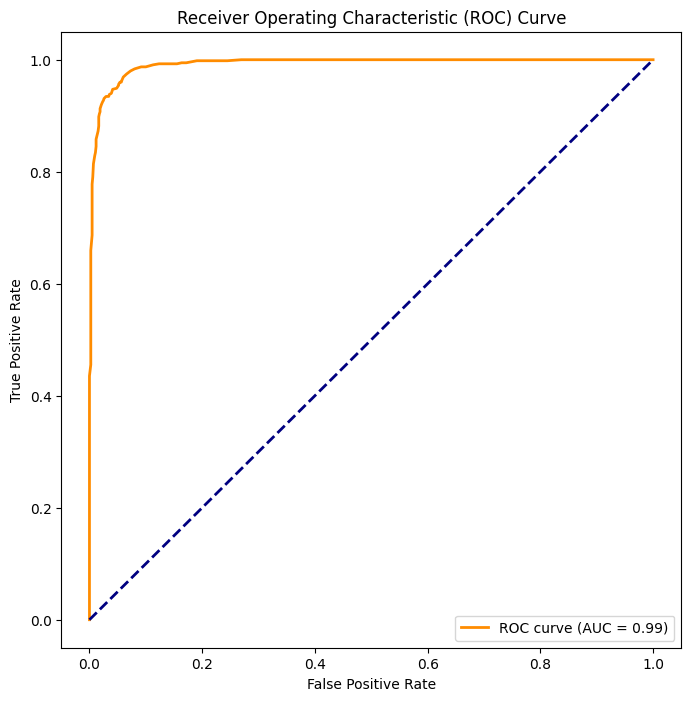

Cross-validation scores: [0.94191242 0.95799821 0.95259392 0.95706619 0.9490161 ]
Mean CV accuracy: 0.9517173684017004
Evaluating decision_tree classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       850
           1       0.89      0.89      0.89       549

    accuracy                           0.91      1399
   macro avg       0.91      0.91      0.91      1399
weighted avg       0.91      0.91      0.91      1399

Confusion Matrix:
[[790  60]
 [ 60 489]]


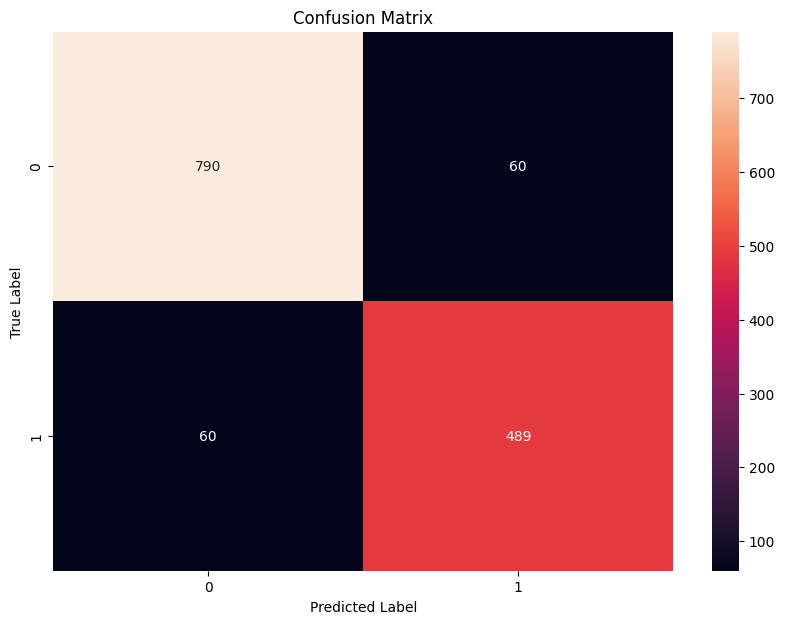

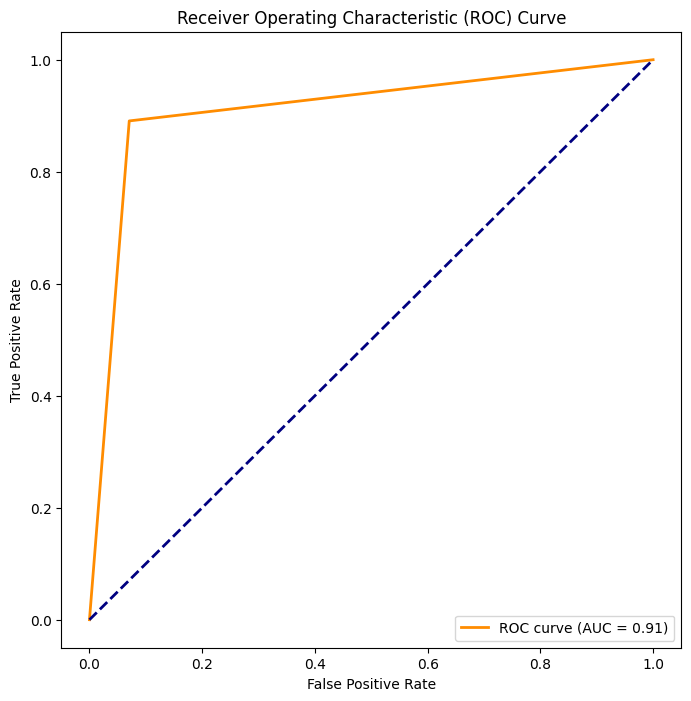

Cross-validation scores: [0.88203753 0.90080429 0.90161002 0.89266547 0.90429338]
Mean CV accuracy: 0.8962821392087555
Evaluating bagging classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       850
           1       0.94      0.93      0.93       549

    accuracy                           0.95      1399
   macro avg       0.95      0.94      0.95      1399
weighted avg       0.95      0.95      0.95      1399

Confusion Matrix:
[[817  33]
 [ 40 509]]


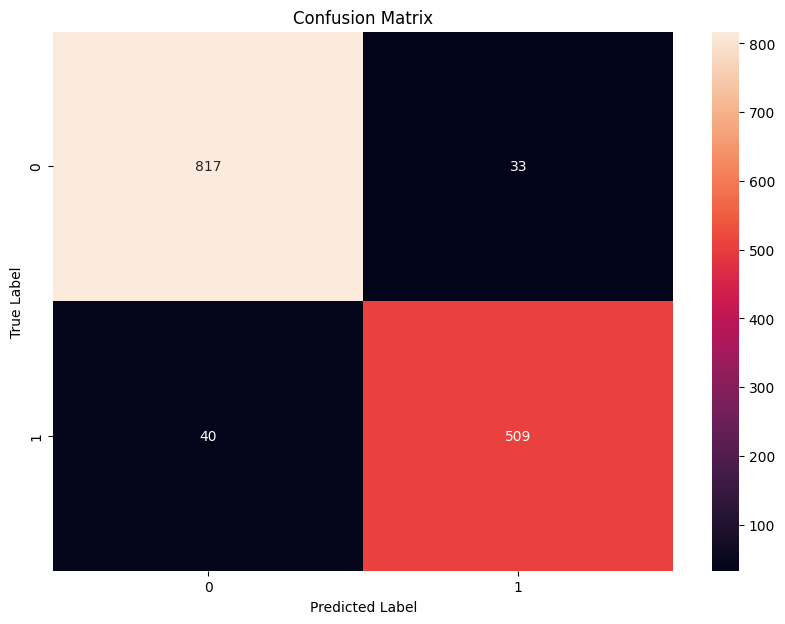

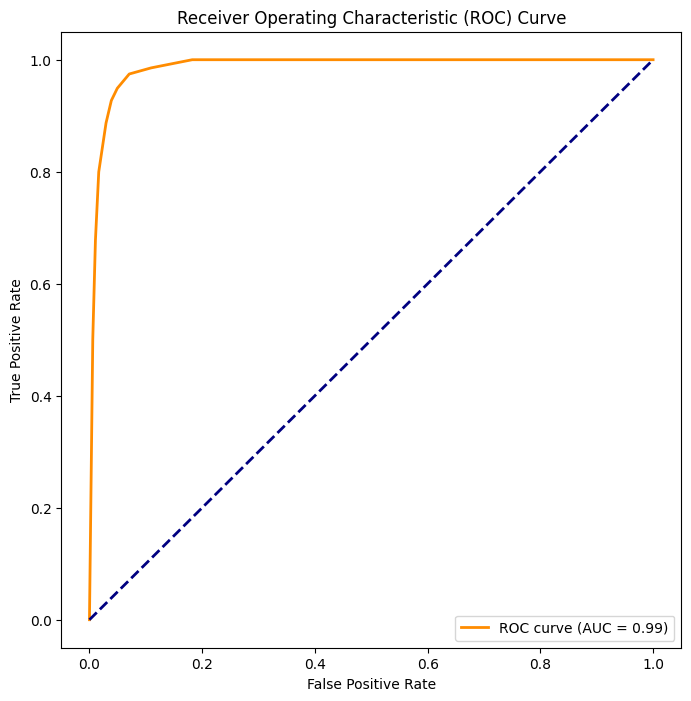

Cross-validation scores: [0.92493298 0.93386953 0.93559928 0.94364937 0.9391771 ]
Mean CV accuracy: 0.9354456525040726
Evaluating boosting classifier:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       850
           1       0.92      0.90      0.91       549

    accuracy                           0.93      1399
   macro avg       0.93      0.93      0.93      1399
weighted avg       0.93      0.93      0.93      1399

Confusion Matrix:
[[806  44]
 [ 53 496]]


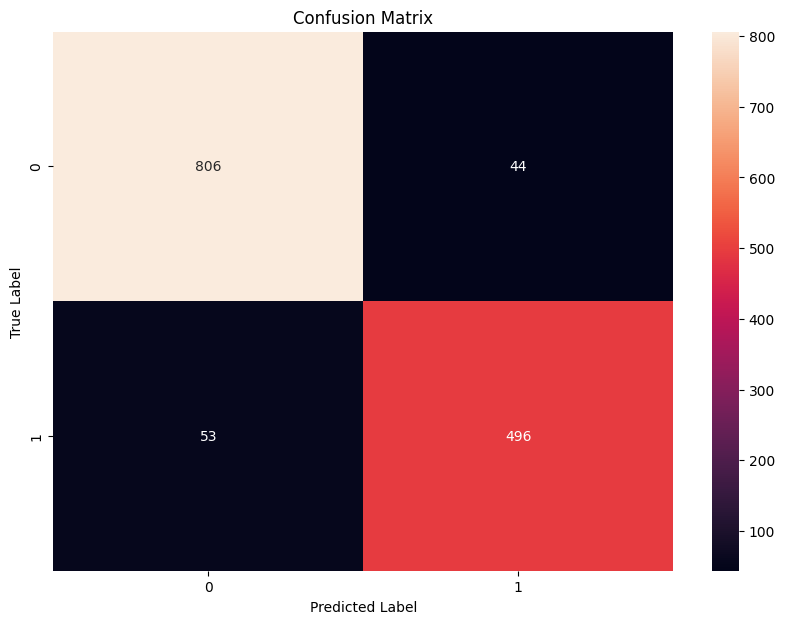

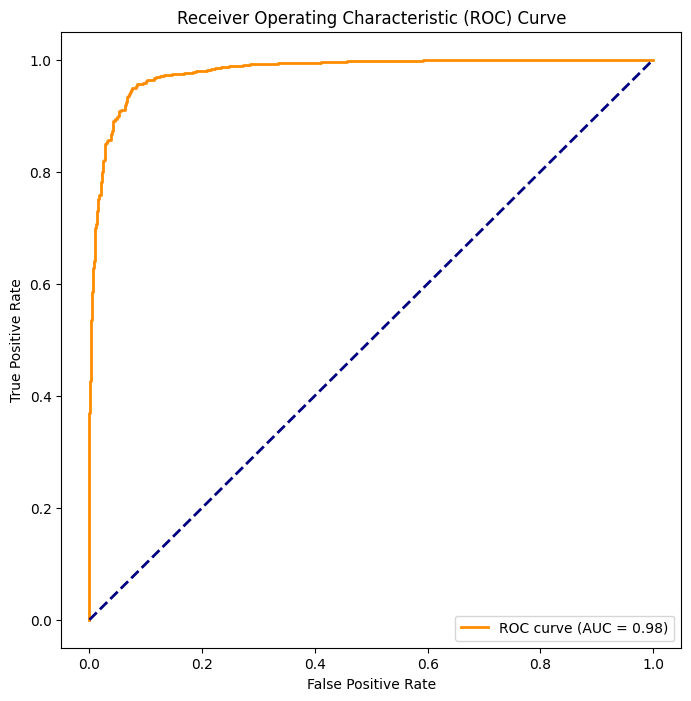

Cross-validation scores: [0.91957105 0.91957105 0.92665474 0.9293381  0.91234347]
Mean CV accuracy: 0.9214956812001516


In [ ]:
def build_classifier(name):
    if name == 'knn':
        return KNeighborsClassifier()
    elif name == 'log_reg':
        return LogisticRegression()
    elif name == 'svm':
        return SVC(probability=True)
    elif name == 'naive_bayes':
        return GaussianNB()
    elif name == 'random_forest':
        return RandomForestClassifier()
    elif name == 'decision_tree':
        return DecisionTreeClassifier()
    elif name == 'bagging':
        return BaggingClassifier()
    elif name == 'boosting':
        return AdaBoostClassifier()

def evaluate_classifier(classifier, X_train_scaled, y_train, X_test_scaled, y_test):
    classifier.fit(X_train_scaled, y_train)
    y_pred = classifier.predict(X_test_scaled)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    # Plot using seaborn for a more attractive presentation
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    y_score = classifier.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    cv_score = cross_val_score(classifier, X_train_scaled, y_train, cv=5)
    print(f"Cross-validation scores: {cv_score}")
    print(f"Mean CV accuracy: {np.mean(cv_score)}")

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluate different classifiers
model_names = ['knn', 'log_reg', 'svm', 'naive_bayes', 'random_forest', 'decision_tree', 'bagging', 'boosting']
for name in model_names:
    classifier = build_classifier(name)
    print(f"Evaluating {name} classifier:")
    evaluate_classifier(classifier, X_train_scaled, y_train, X_test_scaled, y_test)


#HyperParameter Tuning (Gridsearch and Randomized search)



Hyperparameter tuning for knn...
Best Parameters for GridSearchCV (KNeighborsClassifier): {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Hyperparameter tuning for log_reg...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best Parameters for GridSearchCV (LogisticRegression): {'C': 0.1, 'penalty': 'l2'}

Hyperparameter tuning for svm...
Best Parameters for GridSearchCV (SVC): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Hyperparameter tuning for naive_bayes...
Best Parameters for GridSearchCV (GaussianNB): {}

Hyperparameter tuning for random_forest...
Best Parameters for GridSearchCV (RandomForestClassifier): {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 150}

Hyperparameter tuning for decision_tree...
Best Parameters for GridSearchCV (DecisionTreeClassifier): {'max_depth': 10, 'min_samples_split': 5}

Hyperparameter tuning for bagging...
Best Parameters for GridSearchCV (BaggingClassifier): {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 30}

Hyperparameter tuning for boosting...
Best Parameters for GridSearchCV (AdaBoostClassifier): {'learning_rate': 1, 'n_estimators': 150}

Creating and evaluating ensemble classifier...
Ensemble accuracy: 0.9799857040743388
Classification Repo

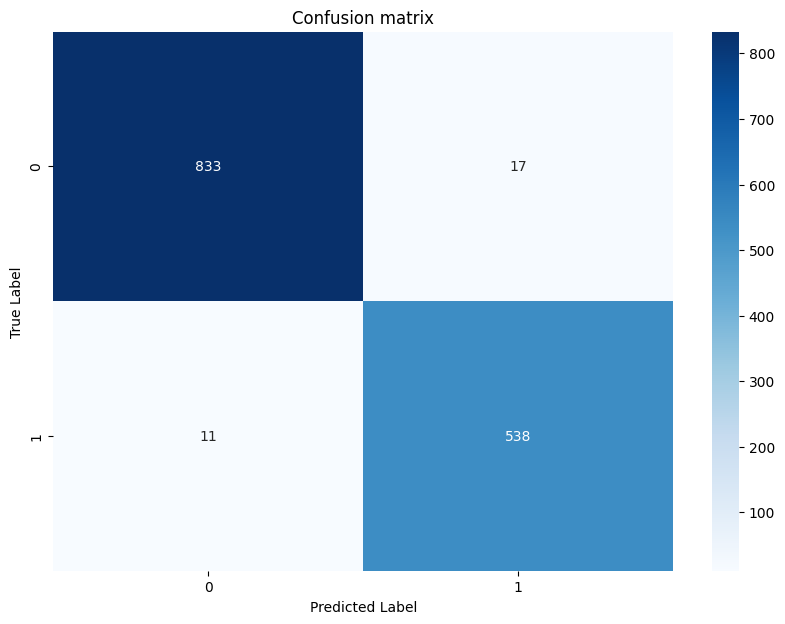

ROC-AUC Score: 0.9977284903032251


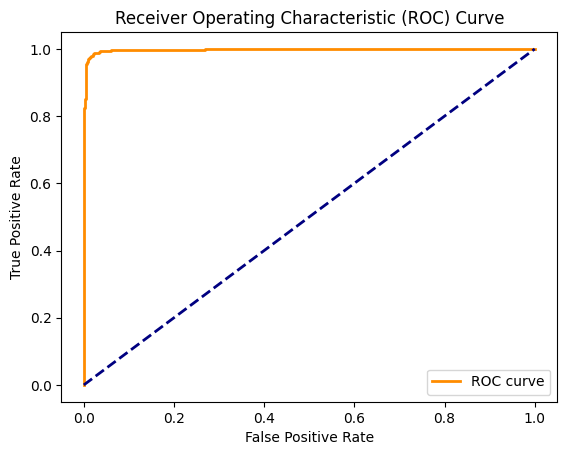

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

def hyperparameter_tuning_combined(classifier, X_train, y_train):
    # Define parameter grid based on the type of classifier
    if isinstance(classifier, KNeighborsClassifier):
        param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
    elif isinstance(classifier, LogisticRegression):
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
    elif isinstance(classifier, SVC):
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
    elif isinstance(classifier, GaussianNB):
        param_grid = {}  # GaussianNB has no hyperparameters to tune
    elif isinstance(classifier, RandomForestClassifier):
        param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    elif isinstance(classifier, DecisionTreeClassifier):
        param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    elif isinstance(classifier, BaggingClassifier):
        param_grid = {'n_estimators': [10, 20, 30], 'max_samples': [0.5, 0.7, 0.9], 'max_features': [0.5, 0.7, 0.9]}
    elif isinstance(classifier, AdaBoostClassifier):
        param_grid = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}
    else:
        raise ValueError(f"Unsupported classifier type: {type(classifier).__name__}")

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters for GridSearchCV ({classifier.__class__.__name__}): {grid_search.best_params_}")

    return grid_search.best_estimator_

def evaluate_ensemble(X_train, y_train, X_test, y_test, models):
    ensemble = VotingClassifier(estimators=models, voting='soft')
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Ensemble accuracy: {accuracy}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Print Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=ensemble.classes_)

    # Calculate and print ROC-AUC score
    y_pred_proba = ensemble.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {roc_auc}")

    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba)

    return ensemble

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    # Plot using seaborn for a more attractive presentation
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Hyperparameter tuning for each classifier
models = []
for name in model_names:
    classifier = build_classifier(name)
    print(f"\nHyperparameter tuning for {name}...")
    best_model = hyperparameter_tuning_combined(classifier, X_train_scaled, y_train)
    models.append((name, best_model))

# Evaluate ensemble classifier
print("\nCreating and evaluating ensemble classifier...")
best_ensemble = evaluate_ensemble(X_train_scaled, y_train, X_test_scaled, y_test, models)


#Manual Testing of the tuned model

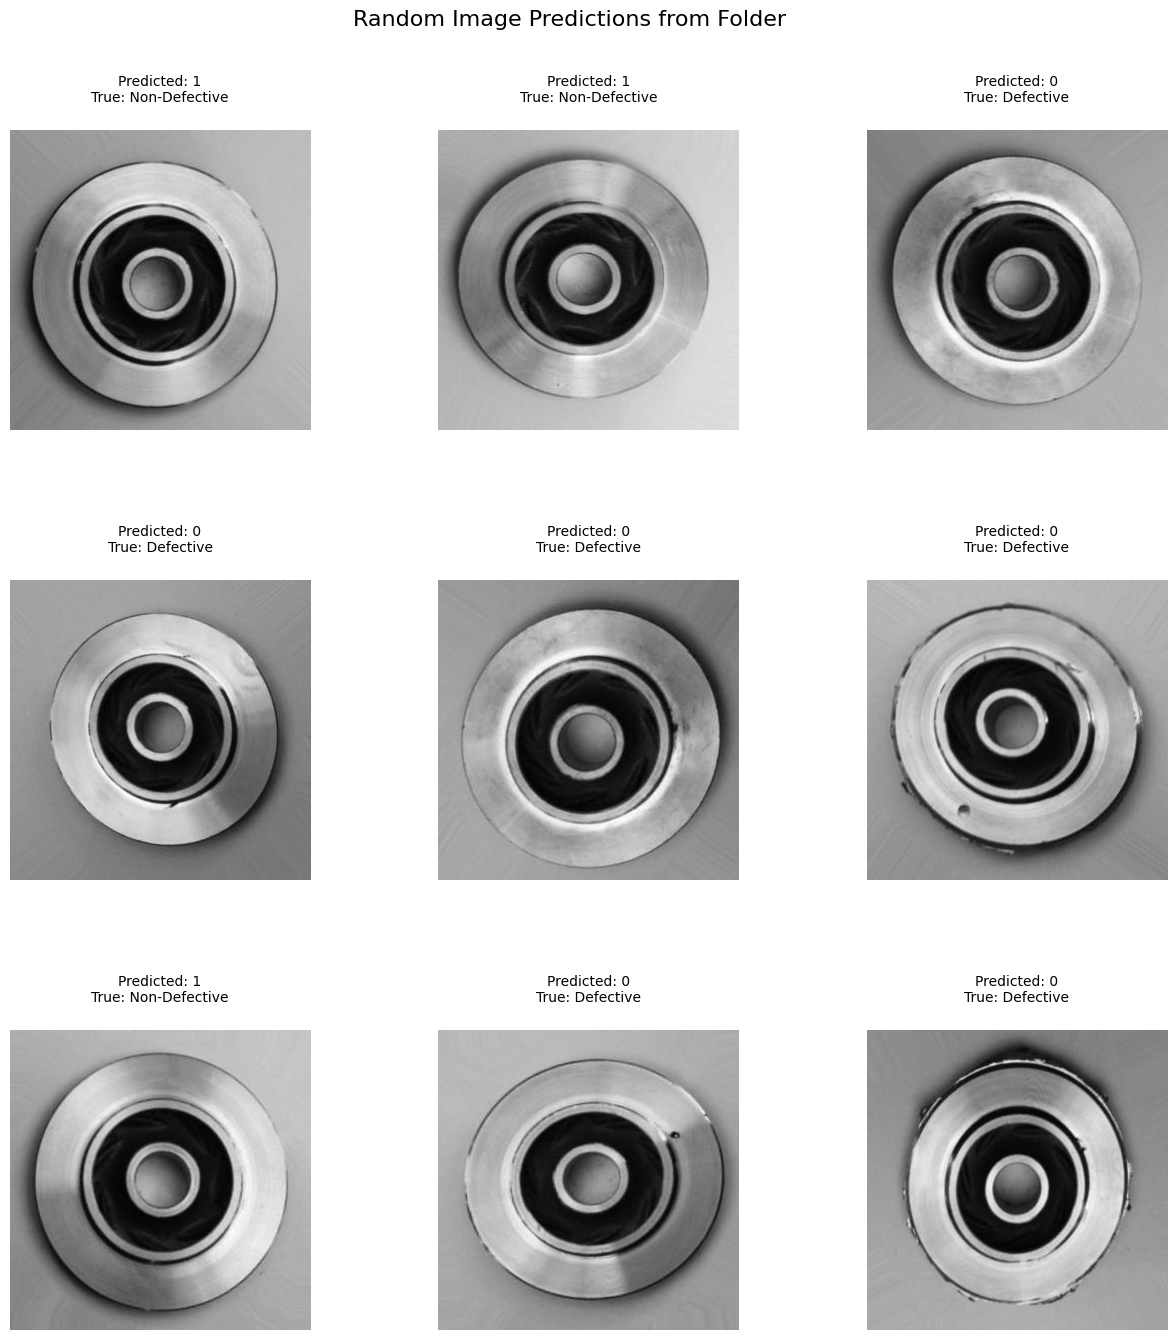

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

def is_image_file(filename):
    for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
        if filename.lower().endswith(ext):
            return True
    return False

def get_true_class_from_filename(filename):
    if 'ok' in filename.lower():
        return 'Non-Defective'
    elif 'def' in filename.lower():
        return 'Defective'
    return 'Unknown'

def preprocess_image_for_prediction(image, pca, scaler, hog_extractor):
    # Resize and grayscale the image
    image_resized = cv2.resize(image, (128, 128))

    # Extract and flatten HOG features
    hog_features = hog_extractor(image_resized)[0]  # Extract only the feature descriptor
    flattened_hog = np.array(hog_features).flatten().reshape(1, -1)

    # Apply PCA and scaling transformations
    scaled_image = scaler.transform(pca.transform(flattened_hog))

    return scaled_image


def display_random_folder_predictions(classifier, pca, scaler, folder, img_size, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid layout
    fig.suptitle('Random Image Predictions from Folder', fontsize=16)
    # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.5, wspace=0.4)
    # Get a list of all image file paths in the folder
    all_images = [os.path.join(folder, f) for f in os.listdir(folder) if is_image_file(f)]

    if not all_images:
        print("No images found in the specified folder.")
        return

    for i in range(3):
        for j in range(3):
            if len(all_images) == 0:  # Check if there are still images left to display
                break

            # Randomly select an image file
            img_path = random.choice(all_images)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Remove the selected image from the list to avoid repetition
            all_images.remove(img_path)

            # Display the original image
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].axis('off')

            # Preprocess the image and predict
            preprocessed_image = preprocess_image_for_prediction(image, pca, scaler, extract_hog_features)
            predicted_class = classifier.predict(preprocessed_image)[0]

            # Get true class from filename
            true_class = get_true_class_from_filename(os.path.basename(img_path))

            # Set title with space for readability
            axes[i, j].set_title(f"Predicted: {predicted_class}\nTrue: {true_class}", fontsize=10, pad=20)

    plt.show()

# Example usage
folder_path = '/content/drive/MyDrive/CastingData/TEST'  # Adjust to the path of your folder
img_size = 128  # The size used during training
display_random_folder_predictions(best_ensemble, pca, scaler, folder_path, img_size)
